# In this notebook....

Using HypnosPy, we first classified sleep using the most common heuristic algorithms, such as Cole-Kripke, Oakley, Sadeh, Sazonov and the Scripps Clinic algorithm.

Once sleep was classified, we derived the well-established sleep metrics, such as arousal, awakening, sleep efficiency, total sleep time and total wake time.

All this was done by simply using the _SleepWakeAnalysis_ and _SleepMetrics_ modules of HypnosPy.

Next, we calculated the Pearson correlation between the sleep metrics and the ones derived from ground truth PSG.

Finally, we produced a compelling visualization of these results using the software.
This visualization extends the finds of [previous research](https://www.nature.com/articles/s41746-019-0126-9) and allows us to understand, for the first time, that although all algorithms perform similarly at detecting total wake time, they all perform better at detecting total sleep time than total wake time and in particular Oakley and Sazonov are better at awakening and arousal detection than the rest of the algorithms.

These findings are particularly informative for large population studies where quantifying awakenings/arousals during the night period is of particular interest for the research question that the study is trying to address.   

In [1]:
from glob import glob
from hypnospy import Wearable, Experiment
from hypnospy.data import RawProcessing
from hypnospy.analysis import SleepWakeAnalysis, Viewer, SleepMetrics
# In the MESA Sleep study, PSG was conducted during one single night and actigraphy during 7 whole days.
# Actigraph and PSG were aligned elsewhere using this overlap dataset: https://sleepdata.org/datasets/mesa/files/overlap
# Hypnospy can easily process the generic data created with the ``RawProcessing'' module shown below.
# Note that all this data (PSG, actigraph and overlap) can be obtained from https://sleepdata.org upon request
file_path = "../data/examples_mesa/collection_mesa_psg/*.csv"

In [2]:
# Configure an Experiment
exp = Experiment()

In [3]:
for inputfile in glob(file_path):
    # This is how a preprocessed actigraph + PSG file looks like:
    #mesaid,linetime,offwrist,activity,marker,white,red,green,blue,wake,interval,dayofweek,daybymidnight,daybynoon,stage,gt
    #1,1900-01-01 20:30:00,0,0.0,0.0,0.07,0.0292,0.0,0.0059,0.0,ACTIVE,5,1,1,0,0
    #1,1900-01-01 20:30:30,0,0.0,0.0,0.07,0.0292,0.0,0.0059,0.0,ACTIVE,5,1,1,0,0
    preprocessed = RawProcessing(inputfile,
                                 cols_for_activity=["activity"],                             # Activity information
                                 col_for_datetime="linetime", strftime="%Y-%m-%d %H:%M:%S",  # Datetime information
                                 col_for_pid="mesaid")                                       # Participant information
    w = Wearable(preprocessed)
    w.change_start_hour_for_experiment_day(15) # We define an experiment day as the time from 15pm to 15pm the next day.
    exp.add_wearable(w)

In [4]:
exp.set_freq_in_secs(30)  # This is not a required step, but shows how easily one can change the data sampling frequency

In [5]:
sw = SleepWakeAnalysis(exp)  # This module allows the use of sleep/wake algorithms for the night that PSG was conducted
for sleep_alg in ["Cole-Kripke", "ScrippsClinic", "Oakley", "Sadeh", "Sazonov"]:
    sw.run_sleep_algorithm(sleep_alg, inplace=True)

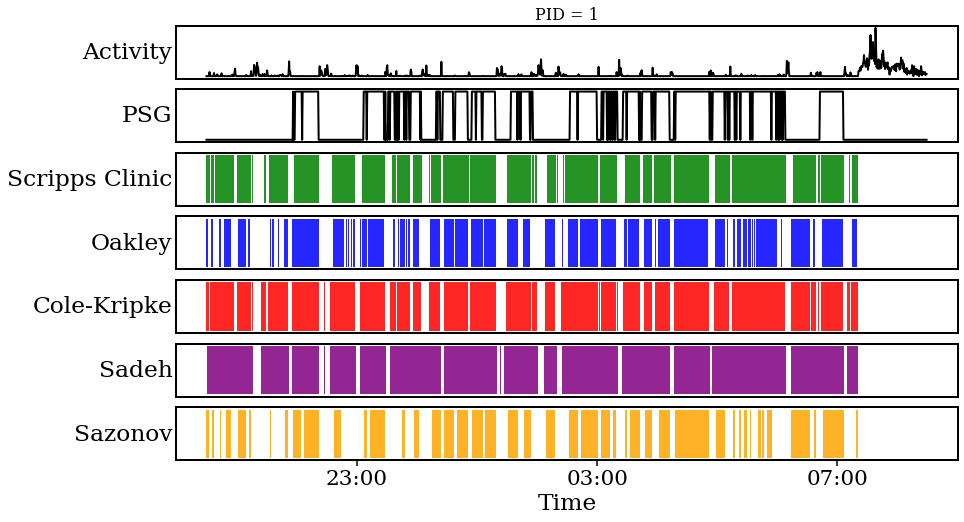

In [6]:
# We can at any time visualize the signals and annotations for one (or all) participants
v = Viewer(exp.get_wearable(pid="1"))
v.view_signals_multipanel(signals=["activity", "gt"], signals_as_area=["ScrippsClinic", "Oakley", "Cole-Kripke", "Sadeh", "Sazonov"],
    select_day=0, zoom=["20:00:00", "09:00:00"], colors={"signal": "black", "area": ["green", "blue", "red", "purple", "orange"]},
    alphas={"area": 0.85}, labels={"signal": ["Activity", "PSG"], "area": ["Scripps Clinic", "Oakley", "Cole-Kripke", "Sadeh", "Sazonov"]})

In [7]:
# Now, we extract sleep metrics and compare the performance of different algorithms
sm = SleepMetrics(exp)
results = []
sleep_metrics = ["sleepEfficiency", "awakening", "arousal", "totalSleepTime", "totalWakeTime"]

In [8]:
for sleep_alg in ["Cole-Kripke", "ScrippsClinic", "Oakley", "Sadeh", "Sazonov"]:
    results.extend(sm.compare_sleep_metrics(ground_truth="gt", wake_sleep_alg=sleep_alg, sleep_metrics=sleep_metrics,
                                            how="pearson"))

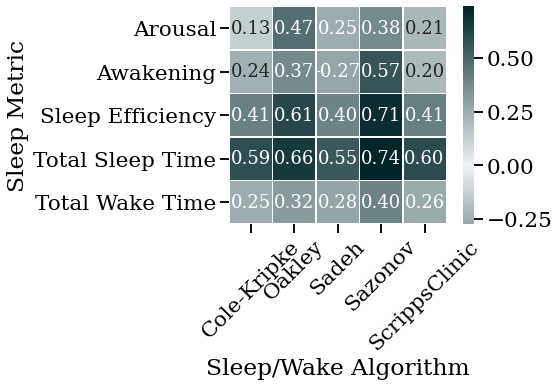

In [10]:
fig = Viewer.plot_sleep_wake_by_metrics_metrics(results, figname='heatmap_sleepalg_metrics.pdf')